# <center>Handwritten Digits Classification


>Alec Turner (260468327)<br>
>Edgar E. Garcia-Cano Castillo (260617750)<br>
>Meng Miao Wu (260534500)<br>
**Kaggle team: Meng**

<a id='top'></a>
# Contents:

<a href='#intro'>1. Introduction</a>

<a href='#methods'>2. Methods</a>
<BLOCKQUOTE>
Data:<BR>
<a href='#a1'>A.1 Dataset</a><BR>
<a href='#a2'>A.2 Preprocessing</a><BR><BR>

Algorithms:<BR>
<a href='#b1'>B.1 Logistic Regression</a><BR>
<a href='#b2'>B.2 Linear SVC</a><BR>
<a href='#b3'>B.3 Neural Network</a><BR>
<a href='#b4'>B.4 CNN</a><BR><BR>
</BLOCKQUOTE>

<a href='#results'>3. Implementation and Results</a>
<BLOCKQUOTE>
Preprocessing:<BR>
<a href='#pre'> Intro</a><BR>
<a href='#rotation'> Rotation</a><BR>
<a href='#noise'> Noise Reduction</a><BR>
<a href='#centering'> Centering</a><BR>

<BR>Learning:<BR>
<a href='#logreg'>Logistic Regression</a><BR>

<a href='#svc'>Linear SVC</a><BR>

<a href='#nn'>Neural Network</a><BR>

<a href='#cnn'>Convolution Neural Network</a><BR>


</BLOCKQUOTE>

<a href='#conclusion'>4. Conclusion</a>

<a href='#statec'>5. Statement of Contributions</a>

<a href='#stateh'>6. Statement of Honesty</a>

<a href='#ref'>7. References</a>

In [2]:
%pylab inline
import matplotlib.image as mpimg
from IPython.display import Image
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import KFold
from sklearn.svm import LinearSVC
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from scipy.signal import fftconvolve
from PIL import Image
import scipy.ndimage
from sklearn import cross_validation
import numpy as np

Populating the interactive namespace from numpy and matplotlib


<a href='#top'>back to top</a><BR>
<a id='intro'></a>
# I. Introduction

The MNIST dataset is a classic setting for machine learning competition. Consisting of a collection of hand written digits, collected and processed slightly to test machine learning algorithms. In this report, a slightly modified version of this dataset will be used to train our own learners.

The modifications consist of rotations by a random angle, rescaling of the image, and a randomly selected texture pattern overlayed on the background. Our goal will be to implement several different models to correctly classify these images based on the digit shown. Four algorithms will be attempted in this report; a simple logistic regression learner to be used as a baseline, a linear SVM model implemented from the scikit-learn python library, and our own fully connected feedforward neural network. The most successful model will be entered into a class-wide competition on Kaggle to compare the accuracy of our learner.

# II. Methods
<a href='#top'>back to top</a><BR>
<a id='a'></a>
## A. Data

<a id='a1'></a>
## A.1 Dataset

The MNIST dataset contains handwritten digits from 0 to 9 represented in cropped images. This dataset has been modified using different transformations (embossing, rotation, rescalling and texture pattern). The original dataset can be downloaded from http://yann.lecun.com/exdb/mnist/. An example of the dataset can be seen below. 


In [3]:
#Load the data
X_train = np.load('dataset/data_and_scripts/train_inputs.npy')
y_train = np.load('dataset/data_and_scripts/train_outputs.npy')
X_test = np.load('dataset/data_and_scripts/test_inputs.npy')
print("Size of the train dataset: {}".format(X_train.shape))
print("Size of the test dataset: {}".format(X_test.shape))

Size of the train dataset: (50000, 2304)
Size of the test dataset: (20000, 2304)


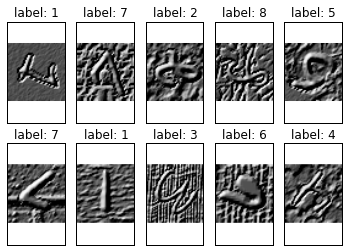

In [4]:
#Display examples 
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):

    img = X_train[i,:].reshape(48, 48)
    ax[i].imshow(img, cmap=cm.gray)
    ax[i].set_title('label: %d ' % (y_train[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.show()

<a href='#top'>back to top</a><BR>
<a id='a2'></a>
## A.2 Preprocessing

To simplify the data, there are a number of methods we can apply to the original images. We will address both the original issues with the MNIST images as well as the modifications made to our data set. The preprocessing methods can be broken down into 3 categories; rotation, centering, and noise reduction.

### Rotation:
Ideally, we would like to have every image of a digit oriented the same way. It may seem easier to have them all oriented vertically, as we are used to seeing them, but as long as each example of a digit has the same orientation we can be satisfied. We can start by setting up helper images to compare against; these will be refered to as filters. Each digit should have a main axis to compare to, the goal of filtering the image is to find which orientation of this axis yields the greatst response from the filter. By rotating every image to the angle of peak response, each example of a specific digit should be oriented the same way.

Below, we set up three filters; a simple cross, a grid, and a vertically oriented cosine gabor. The first two are simple enough, giving a clear x-y axis to compare against. The gabor filter is a common means of edge detection in computer vision [3] that is sensitive (in this case) to vertical lines. This should respond similar to a simple vertical line, but yields a greater response when centered over a line.

### Noise Reduction:

In this report, we will consider only a very simple method of noise reduction to convert the image from greyscale to black-white.  A threshold will be set and all values greater will be set to white (255). Any remaining values will be set to black (0). The resulting image will lose some of its detail, but will be dramatically simpler to analyse as will become aparent in the implementation section.

### Centering:

While many algorithms benefit from centering of the images by their center of mass, others like linear SVM and k-nearest neighbour perform better under fitting the image with a bounding box. We will implement both of these to determine the optimal combination of preprocessing and learning.

**Center of Mass:**

After setting a threshold, each pixel becomes either a 0 or a 1 (scaled to 255). This makes it easy to calculate a center of mass using x,y coordinates.

$ (x,y)_{com} = \frac{\Sigma_{x,y} (x,y) \cdot I(x,y)}{\Sigma_{x,y} {- \cdot I(x,y)} } $

This becomes a sum of all dark points (x,y) divided by the total number of these points. This is achieved by first inverting the image before and after the center of mass calculation.

**Bounding Box:**

A bounding box constricts the domain of the image as tightly as possible. We implement this by first setting a threshold on the allowed noise and then finding the left,right,upper, and lower-most portions of the image as the first column or row with a dark pixel. The image is then cropped and resized to its original size via a quadratic interpolation. The process is shown visuually below.

In [ ]:
img0=mpimg.imread('bbox0.png')
img1=mpimg.imread('bbox1.png')
img2=mpimg.imread('bbox2.png')
figure(num=None, figsize=(12, 6))
subplot(1,3,1)
axis('off')
imshow(img0)
subplot(1,3,2)
axis('off')
imshow(img1)
subplot(1,3,3)
axis('off')
imshow(img2)

## B. Algotihms

<a href='#top'>back to top</a><BR>
<a id='b1'></a>
### B.1 Logistic Regression

Logistic regression is one the simplest linear classifiers, the main constraint is that the data has to be lenearly separable. The output is obtained by a linear combination of the features. In this report, we used logistic regression classifier, as a base-line method to compare with other more complex classifiers.


<a href='#top'>back to top</a><BR>
<a id='b2'></a>
### B.2 LinearSVM

This learning classifier allows the creation of hyper-planes among clusters of similar data points. The algorithm attempts to maximize how clear the hyper-plane is, such that new data can be classified simply by computing its location in space.

<a href='#top'>back to top</a><BR>
<a id='b3'></a>
### B.3 Neural Networks

A neural network is also called a multi-layer perceptron. The perceptron is a concept developed by F. Rosenblatt [2], that at the same time it is based on the idea of the neuron [6]. The neurons are cells in the brain that are interconected and they are on charge of trasmitting chemical and electrical signals.


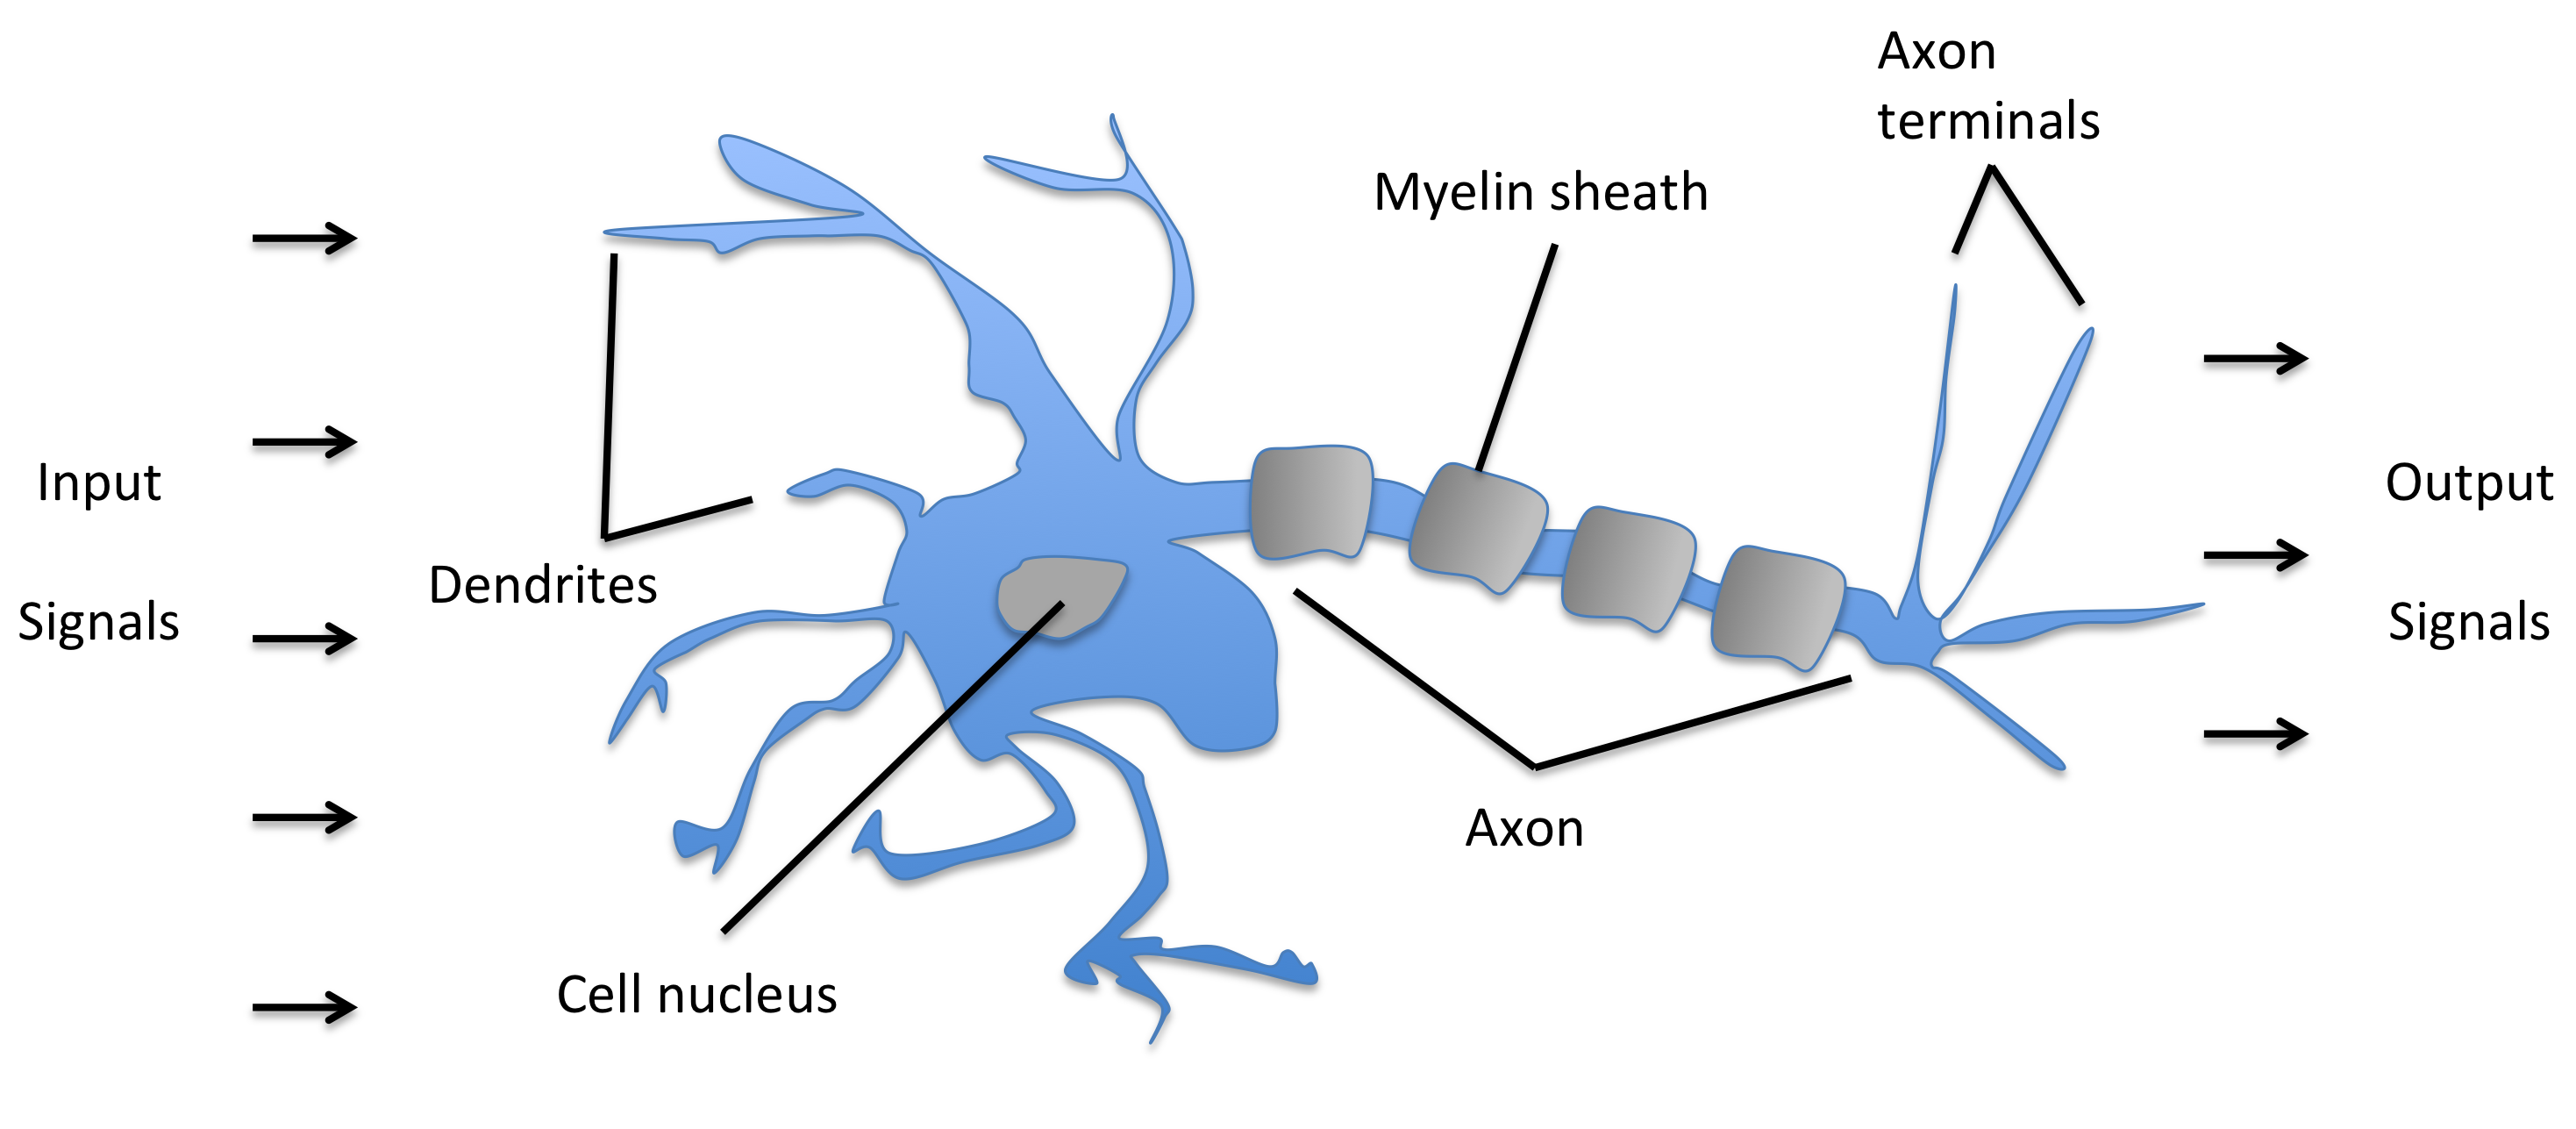

In [4]:
Image(filename='./img/02_01.png', width=500) 

The idea behind the perceptron is to emulate how the neurons work in the brain. There is a layer of inputs that is multiplied by weight coefficients, this creates the net input. Then, there is an activation function (linear conbination of inputs and weights) that fires or not as an answer. This representation could be used to do binary classification, to predict if a sample belongs to one class or the other. 

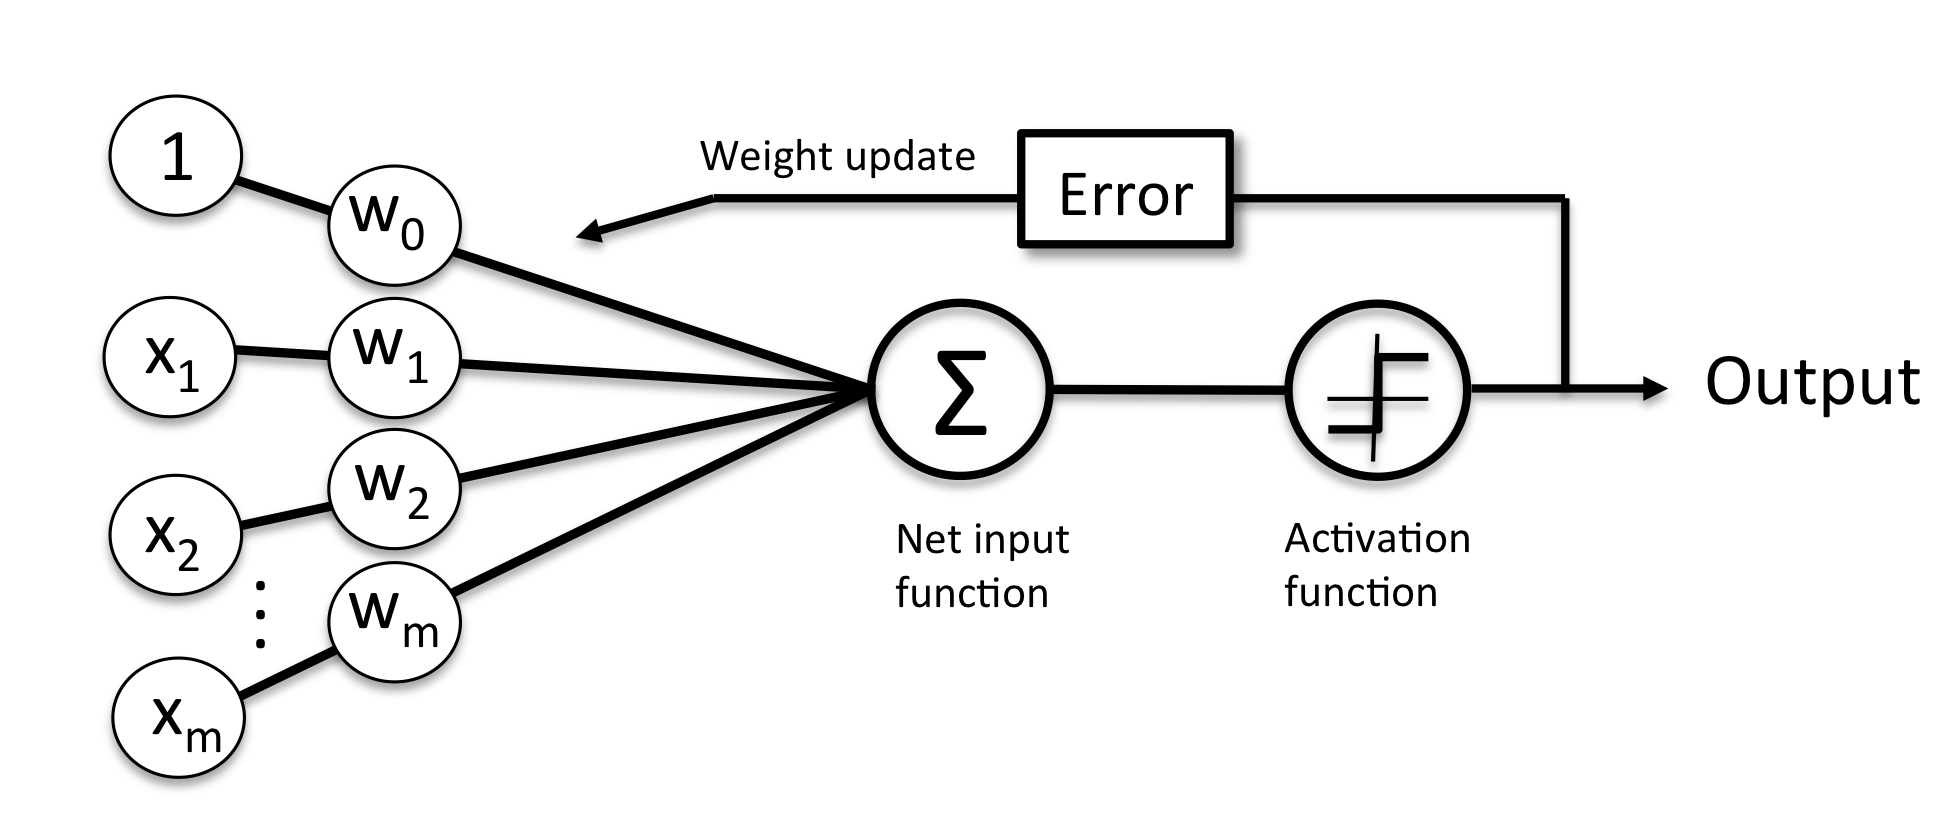

In [5]:
Image(filename='./img/02_04.png', width=500) 

The net input $(z)$ is represented as follows:

$$
x = \begin{bmatrix} x_1 \\ \vdots \\ x_m \end{bmatrix},
w = \begin{bmatrix} w_1 \\ \vdots \\ w_m \end{bmatrix} \rightarrow
z = (w_1 x_1 +...+ w_m x_m ) = \sum_{j=0}^{m} x_j w_j  = w^T x \ \text{(vector dot product)}
$$

Where the activation function $(h(\cdot))$, which basically is the unit step function, can be used to discriminate between two classes (it returns an integer class label):

$$
h(z) =
  \begin{cases}
    1  & \quad \text{if } z \geq \text{threshold} \\
    -1 & \quad \text{otherwise }\\
  \end{cases}
$$

As can be seen above, once the output is calculated the weights are updated simultaneously:

$$
w_j = w_j + \Delta w_j;\\
\text{where:}\\
\Delta w_j = \eta(y^{(i)} - h(z)^{(i)})x_j^{(i)}
$$

Where $\eta$ is the learning rate, $y^{(i)}$ is the true class and $h(z)^{(i)}$ is the output of the $i^{th}$ training sample. As a constraint, the convergence of the perceptron is limited to the linear separability of the classes.

Taking into account the idea of the perceptron, a neural network can be conceived as a multi-layer perceptron. The basic architecture behind of a neural network is composed of three layers: the input, the hidden and the output layers. The hidden units are connected with all of the input's units, and the output units with all of the hidden units. 

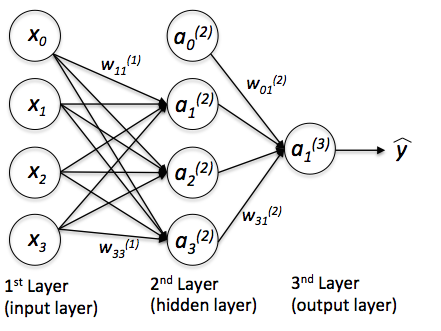

In [6]:
Image(filename='./img/12_02.png', width=400) 

The neural network can be summarized in the following steps:
>1. Initialize the weights
>2. Propagate the data through the network to generate the output (feed-forward)
>3. Based on the output, minimize a cost function
>4. Back propagate the error to the hidden layers to update the weights and the model
>5. Repeat steps 2-5 for n-iterations

In order to be clear about the formulation of neural networks, the following notation is used:
>* $l$ is the layer
>* $x_m^{(i)}$ the $i^{th}$ sample
>* $a^{(l)}$ activation unit in layer $l$
>* $w_{j,k}^{(l)}$ connection between the $k^{th}$ unit in layer $l$ to the $j^{th}$ unit in layer $l+1$
>* $W^{l} \in \Re^{hx[m+1]}$ $h$ is the number of hidden layers, $m+1$ is the number of inputs including the bias unit
>* $y_{true}$ true class label

#### B.3.1 Feed-forward

Considering that this is a fully-connected network, where all the units in layer $l$ provide input to all the units in layer $l+1$, it is possible to calculate the activation as:

$$
Z^{(2)} = W^{(1)}[A^{(1)}]^{(T)} \\
\text{where:} \\
A^{(1)} \space \text{: features vector}\\
W^{(1)} \space \text{: weights vector}\\
Z^{(2)} \space \text{: net input}
$$

After that, the activation function is applied in layer 2.

$$
A^{(2)} = h(Z^{(2)})
$$

Finally, in the output layer the activation is

$$
Z^{(3)} = W^{(2)}[A^{(2)}]^{(T)} \\
$$

and then the sigmoid activation function is calculated to obtain the continuous valued output

$$
A^{(3)} = h(Z^{(3)})
$$

#### B.3.2 Cost function

Based on the log-likelihood function used in logistic regresion, the cost function $J$ can be written as follows adding the L2 regularization. In this equation the sum of the weights for each layer is calculated without the bias term.

$$
J(w)= -\bigg[\sum_{i=1}^{n} \sum_{j=1}^{t} y_j^{(i)} log\big(h(z^{(i)})j\big) + \big(i-y_j^{(i)}\big)log \big(1-h(z^{(i)})j\big)\bigg] + \frac{\lambda}{2}\sum_{l=1}^{L-1}\sum_{i=1}^{ul} \sum_{j=1}^{ul+1}\big(W_{j,i}^{(l)}\big)^{2}
$$

Here, $t$ is the output vector, $j$ are the activation units, $i$ is the index of a sample and $l$ is the layer.

#### B.3.3 Back propagation

The backpropagation algorithm is used in neural networks to update the weights in the layers by means of gradient descent as optimization algorithm. The derivation of the cost function is written as follows:

$$
\frac{\partial J(W)}{\partial \big(W_{j,i}^{(l)}\big)}  = a_j^{(l)} \delta_i^{(l+1)}
$$

And the derivatives are calculated as follows:

$$
\delta^{(3)} = a^{(3)}-y_{true} \space\space \text{; error vector in the output layer}\\
$$

$$
\delta^{(2)} = \big(W^{(2)}\big)^{T} * \delta^{(3)} \frac{\partial h(z^{(2)})}{\partial z^{(2)}} \space \space \text{; (∗) means element-wise multiplication}\\
$$

$$
\text{where:} \\
$$

$$
\frac{\partial h(z^{(2)})}{\partial z^{(2)}} = (a^{2}*(1-a^{2})) \space \space \text{; derivative of the sigmoid activation function}\\
$$

<a href='#top'>back to top</a><BR>
<a id='b4'></a>
### B.4 CNN 

Convolutional Neural Networks(CNN) are variations of MLP, also known as neural networks. They are inspired by the receptive field in the visual cortex, formed by individual neurons tiling and overlapping together to cover the entire visual field. <br\>

<img src="http://i.stack.imgur.com/HyAs5.png",width=500>

The basic difference from NN with fully connected layers is CNN uses convolutional layers with nonlinear activation functions to reshape and resample the next layer. Therefore, each layer looks at local portions of the image. The notion of local connections plays an important role here, the outputs of the previous layer is connected to the inputs of the next layer. Each layer is computed with different filters to compute subsets that have the same parameters. Another important aspect in CNN is max-pooling that provides invariance to image modification, such as rotation and scaling. 
The first two layers are convolutional pooling layers which are constructed by first filtering the image size, then maxpooling to reduce this again. The third layer is a fully connected hidden layer to all outputs from first layer. It have sigmoidal activation function. The last layer classifies the previous layer’s output using logistic regression. The model is trained by stochastic gradient descent. Similarly to the regular NN, backpropagation is used.

# III. Implementation and Results

<a href='#top'>back to top</a><BR>
<a id='pre'></a>
## A. Pre-processing

Before the input images can be modified, some auxilliary functions will be necessary. We start by defining functions to load data

In [1]:
#Load the data from npy file
def loadData(train,test,verbose=True):

    X_train = np.load('dataset/data_and_scripts/train_inputs.npy')
    Y_train = np.load('dataset/data_and_scripts/train_outputs.npy')
    X_test = np.load('dataset/data_and_scripts/train_inputs.npy')
    Y_test = np.load('dataset/data_and_scripts/train_outputs.npy')

    if(verbose):
        print("Size of the train dataset: {}".format(train[1]-train[0]))
        print("Size of the test dataset: {}".format(test[1]-test[0]))

    X_train = X_train[train[0]:train[1]]
    Y_train = Y_train[train[0]:train[1]]
    X_test = X_test[test[0]:test[1]]
    Y_test = Y_test[test[0]:test[1]]
    
    return [X_train,Y_train,X_test,Y_test]

#get 48x48 image matrix from a single example
def getImage(example):
    #run on one example
    s = int(sqrt(shape(example)[0]))
    im = np.reshape(example,(s,s))
    im = im*255
    return Image.fromarray(im)

To demonstrate these methods, let's look at how they affect a single image. Below is the original image we will be considering:

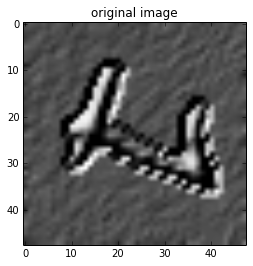

In [4]:
#load the data and extract the image
x = np.load('dataset/data_and_scripts/train_inputs.npy')[0]
im = getImage(x)

#display the original image
figure()
title('original image')

imshow(im,cmap=cm.Greys_r)

<a href='#top'>back to top</a><BR>
<a id='rotation'></a>
### A.1. Rotation: 
#### Filters
Several different filters are created for testing different preprocessing methods. In particular these filters should help in finding a useful orientation for the processed image. It should be noted that the images need not be oriented normally to be useful; each image should yield a peak response to the filters at an orientation specific to that digit.

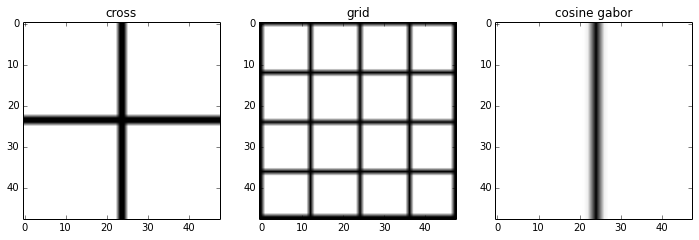

In [5]:
#make a white cross on a black background, 2 pixels wide
def makeCross(s):
    s = int(s)
    icross = np.ones((s,s))
    icross[int(s/2-1),:] = 0
    icross[int(s/2),:] = 0
    icross[:,int(s/2-1)] = 0
    icross[:,int(s/2)] = 0
    return icross*255

#make a white grid on a black background. Defined by image width s and divisions N
def makeGrid(s,N=4):
    s = int(s)
    grid = 255*np.ones((s,s))
    for i in range(int(s/N)):
        grid[:,int(N*i)] = 0
        grid[int(N*i),:] = 0
    grid[:,s-1] = 0
    grid[s-1,:] = 0        
    return grid

#creates a cosine gabor useful for edge detection
def makeGabor(s,kx,ky,mux,muy,sigx,sigy):
    s = int(s)
    cs = np.array(zeros((s,s)))
    gauss = np.array(zeros((s,s)))

    kx = 0
    ky = 1
    mux = s/2
    muy = s/2
    sigx = 1
    sigy = 1

    for i in range(s):
        for j in range(s):
            cs[i,j] = 255*(1-cos(kx*i + ky*j))
            gauss[i,j] = 255*(1-(1/(sigx*sigy*2*np.pi)*exp(-(i-mux)**2/(2*sigx**2)-(j-muy)**2/(2*sigy**2))))

    return np.dot(cs,gauss)


figure(num=None, figsize=(12, 6))
subplot(1,3,1)
title('cross')
imshow(makeCross(48),cmap=cm.Greys_r)
subplot(1,3,2)
title('grid')
imshow(makeGrid(48,12),cmap=cm.Greys_r)
subplot(1,3,3)
title('cosine gabor')
imshow(makeGabor(48,1,0,24,24,1,1),cmap=cm.Greys_r)

Applying one of these filters, we can rotate the image until the response is maximized

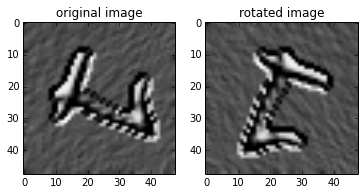

In [6]:
def rotation(image, steps):
    s = int(floor(sqrt(shape(image)[0])))
    
    cr = makeGabor(s,0,2,s/2,s/2,1,1)
    maxconv = 0
    maxang = 0    
    
    for i in range(steps):
        ang = i*360/steps
        im = image.rotate(ang)
        con = fftconvolve(im, cr, mode='full')
        val = np.mean(con)
        
        if(val > maxconv):
            maxconv = val
            maxang = ang
        
    return image.rotate(maxang)

#calculate best rotation
rotated = rotation(im,360)

#compare the two images
figure()
subplot(1,2,1)
title('original image')
imshow(im,cmap=cm.Greys_r)
subplot(1,2,2)
title('rotated image')
imshow(rotated,cmap=cm.Greys_r)

<a href='#top'>back to top</a><BR>
<a id='noise'></a>
### A.2. Noise Reduction
There turns out to be a lot of noise in these images, but this can be quickly eliminated by setting a threshold on the image.

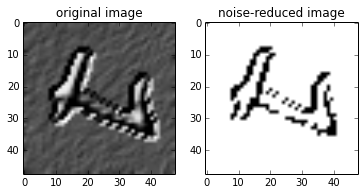

In [7]:
def threshold(image, thresh):
    image = 255/np.max(image)*image
    
    low = image < thresh
    high = image >= thresh
    image[low] = 0
    image[high] = 255
    return image

#apply threshold of 1 (very low)
im_thresh = threshold(im,1)

#compare images
figure()
subplot(1,2,1)
title('original image')
imshow(im,cmap=cm.Greys_r)
subplot(1,2,2)
title('noise-reduced image')
imshow(im_thresh,cmap=cm.Greys_r)

<a href='#top'>back to top</a><BR>
<a id='centering'></a>
### A.3. Centering
The first method, creating a bounding box containing the image, relies on the input image having had its noise reduced enough that the first dark pixel in each row or column from an edge belongs to the digit. For noisier data, this should be altered to be less strict as to where it sets the boundaries.

The center of mass method has no such restrictions, but for this dataset does not dramatically alter the images as they are almost perfectly centered to begin with.

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:64: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:69: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


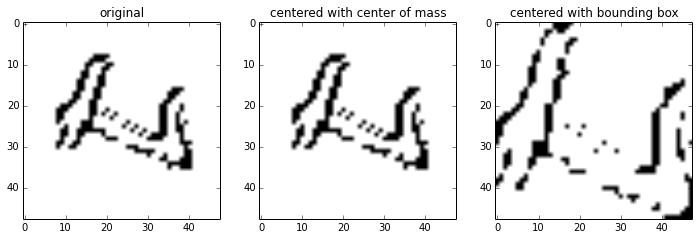

In [8]:
def centerImage(image, method='com'):    

    image = np.array(image)
    s = np.shape(image)[0]
    
    if(method=='bbox'):
        left = 0
        right = s-1
        top = 0
        bottom = s-1
        
        for i in range(s):
            if(left == 0 and np.min(image[:,i]) < 255):   #left edge found
                left = i
            if(right == s-1 and np.min(image[:,s-1-i]) < 255):    #right edge found
                right = s-1-i
            if(top == 0 and np.min(image[i,:]) < 255):   #left edge found
                top = i
            if(bottom == s-1 and np.min(image[s-1-i,:]) < 255):    #right edge found
                bottom = s-1-i

        #crop out excess
        newIm = image[top:bottom,left:right]

        #resize image to sxs
        shape = newIm.shape
        scale = (s/shape[0],s/shape[1])
        newIm = scipy.ndimage.zoom(newIm, scale, order=2)

        #rescale values 0-255
        newIm = 255/np.max(newIm)*newIm
        newIm = threshold(newIm,20)
            
        return newIm
            
    elif(method=='com'):
        image = (1/255)*(255 - threshold(image,1))    #all points weighted equally

        #calculate center of mass
        xsum = 0
        ysum = 0
        count = 0
        for i in range(s):
            for j in range(s):
                if(image[i,j] > 0):
                    xsum+=i
                    ysum+=j
                    count+=1
        com = (xsum/count,ysum/count)
        
        #center about COM
        dx = np.floor(com[0]-(s-1)/2)
        dy = np.floor(com[1]-(s-1)/2)
    
        dx,dy
    
        #center about COM
        dx = np.floor(com[0]-(s-1)/2)
        dy = np.floor(com[1]-(s-1)/2)

        if(dx > 0):
            newIm = np.pad(image,((0,0),(dx,0)), mode='constant')[:, :-dx]
        else:
            newIm = np.pad(image,((0,0),(0,-dx)), mode='constant')[:, -dx: ]

        if(dy > 0):
            newIm = np.pad(image,((dy,0),(0,0)), mode='constant')[:-dy, :]
        else:
            newIm = np.pad(image,((0,-dy),(0,0)), mode='constant')[-dy:, : ]

        return 255*(1-newIm)
        
    else:
        print("invalid method: '{}'".format(method))
       
    
# apply both methods of centering the noise-reduced image
im = threshold(im,1)

im_com = centerImage(im,'com')
im_bbox = centerImage(im,'bbox')

#display comparison
figure(num=None, figsize=(12, 6))
subplot(1,3,1)
title('original')
imshow(threshold(im,1),cmap=cm.Greys_r)
subplot(1,3,2)
title('centered with center of mass')
imshow(im_com,cmap=cm.Greys_r)
subplot(1,3,3)
title('centered with bounding box')
imshow(im_bbox,cmap=cm.Greys_r)

Processing a single example image becomes quite simple once the helper functions are defined:

In [9]:
#execute on each example
def process(ex):

    im = getImage(ex)
    im = threshold(im,1)
  
    im_com = centerImage(im,'com')
    im_bbox = centerImage(im,'bbox')

    im_com = rotation(im_com,360)
    im_box = rotation(im_bbox,360)

    return [im_com,im_bbox]

Putting it all together looks something like this:

In [11]:
#Set the size of the dataset
train=(0,50000)
test=(0,20000)

X_train,Y_train,X_test,Y_test = loadData(train, test, True)

strain = shape(X_train[:,0])[0]
stest = shape(X_test[:,0])[0]
elements = shape(X_train[0,:])[0]

y_train = Y_train    #true values for training set
y_test = Y_test      #true values for test set

x_train = X_train    #examples for training set (unprocessed)
x_test = X_test      #examples for test set (unprocessed)
    
im_train_com = np.zeros((strain,elements))    #examples for training set (processed with com)
im_train_bbox = np.zeros((strain,elements))   #examples for training set (processed with bbox)
im_test_com = np.zeros((stest,elements))    #examples for test set (processed with com)
im_test_bbox = np.zeros((stest,elements))   #examples for test set (processed with bbox)

for i in range(strain):
    [im_com,im_bbox] = process(X_train[i])
    
    im_train_com[i] = im_com.reshape(elements)
    im_train_bbox[i] = im_bbox.reshape(elements)
    
for i in range(stest):
    [im_com,im_bbox] = process(X_test[i])

    im_test_com[i] = im_com.reshape(elements)
    im_test_bbox[i] = im_bbox.reshape(elements)
    
    
#convert to numpy matrix
y_train = np.array(y_train)
y_test =  np.array(y_test)

x_train =  np.array(x_train)
im_train_com = np.array(im_train_com)
im_train_bbox = np.array(im_train_bbox)

x_test =  np.array(x_test)
im_test_com = np.array(im_test_com)
im_test_bbox =  np.array(im_test_bbox)

Size of the train dataset: 50000
Size of the test dataset: 20000


C:\Anaconda\envs\mkl_libraries\lib\site-packages\ipykernel\__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


The dataset contains 50000 examples for the training, from them just 10000 are used for cross-validation where 80% is for training, and 20% testing, this due to the computational cost. Once that the optimal parameters have been found, the 50000 samples are used to generate the final model where 70% is for training and 30% is for testing. Three datasets were used in logistic regression, linearSVC and neural network. The first one is the *original* (with no modifications), the second one is the *centered with center of mass* (**com**) and the third one the *centered with bounding box* (**bbox**).<br><br>
The implemenation of logistic regression and linearSVC was made using the well-known scikit-learn package, where cross-validation was used to obtain the best value of C.

<a href='#top'>back to top</a><BR>
<a id='logreg'></a>
## B. Logistic Regression

In [12]:
features_train, features_test, labels_train, labels_test =\
   cross_validation.train_test_split(X_train, y_train, test_size=0.3, random_state=42)
    
features_train_com, features_test_com, labels_train, labels_test =\
   cross_validation.train_test_split(im_train_com, y_train, test_size=0.3, random_state=42)

features_train_bbox, features_test_bbox, labels_train, labels_test =\
   cross_validation.train_test_split(im_train_bbox, y_train, test_size=0.3, random_state=42)

In [48]:
#x_train =  np.array(x_train)
#im_train_com = np.array(im_train_com)
#im_train_bbox = np.array(im_train_bbox)

max_sample = 10000

X = x_train[0:max_sample,:]
y = y_train[0:max_sample]


#Configuration parameters
C = np.logspace(-2, 10, 5)
tuned_parameters = dict( C=C)
cv = StratifiedShuffleSplit(y, n_iter=5, test_size=0.2, random_state=2015)

#Cross-validation
t0 = time()
grid = GridSearchCV(LogisticRegression(),param_grid=tuned_parameters, cv=cv)
grid.fit(X, y)
print(grid.best_estimator_)
print('Time : ' + "%.4f" % (time()-t0) + ' seconds') 

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
Time : 4982.1579 seconds


In [33]:
#Train the classifier with the best C value normal data
t0 = time()
clflg = LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
clflg.fit(features_train,labels_train)
print('Training time : ' + "%.4f" % (time()-t0) + ' seconds') 

Training time : 84.7192 seconds


In [34]:
#Train the classifier with the best C value com data
t0 = time()
clflg_com = LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
clflg_com.fit(features_train_com,labels_train)
print('Training time : ' + "%.4f" % (time()-t0) + ' seconds') 

Training time : 293.7987 seconds


In [35]:
#Train the classifier with the best C value bbox data
t0 = time()
clflg_bbox = LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
clflg_bbox.fit(features_train_bbox,labels_train)
print('Training time : ' + "%.4f" % (time()-t0) + ' seconds') 

Training time : 160.2206 seconds


In [38]:
#Accuracy
lgpred_train = clflg.predict(features_train)
lgpred_test = clflg.predict(features_test)
print('Training accuracy normal: %.4f%%' % accuracy_score(labels_train, lgpred_train))
print('Test accuracy normal: %.4f%%' % accuracy_score(labels_test, lgpred_test))

lgpred_train_com = clflg_com.predict(features_train_com)
lgpred_test_com = clflg_com.predict(features_test_com)
print('Training accuracy com: %.4f%%' % accuracy_score(labels_train, lgpred_train_com))
print('Test accuracy com: %.4f%%' % accuracy_score(labels_test, lgpred_test_com))

lgpred_train_bbox = clflg_bbox.predict(features_train_bbox)
lgpred_test_bbox = clflg_bbox.predict(features_test_bbox)
print('Training accuracy bbox: %.4f%%' % accuracy_score(labels_train, lgpred_train_bbox))
print('Test accuracy bbox: %.4f%%' % accuracy_score(labels_test, lgpred_test_bbox))

Training accuracy normal: 0.4736%
Test accuracy normal: 0.3665%
Training accuracy com: 0.4335%
Test accuracy com: 0.2379%
Training accuracy bbox: 0.4610%
Test accuracy bbox: 0.2585%


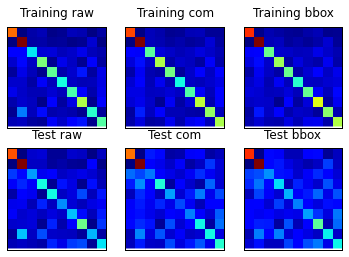

In [39]:
from sklearn.metrics import confusion_matrix
cmlg_train_normal = confusion_matrix(labels_train, lgpred_train)
cmlg_train_com = confusion_matrix(labels_train, lgpred_train_com)
cmlg_train_bbox = confusion_matrix(labels_train, lgpred_train_bbox)

cmlg_test_normal = confusion_matrix(labels_test, lgpred_test)
cmlg_test_com = confusion_matrix(labels_test, lgpred_test_com)
cmlg_test_bbox = confusion_matrix(labels_test, lgpred_test_bbox)

#Display examples 
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True)
ax = ax.flatten()

ax[0].matshow(cmlg_train_normal)
ax[0].set_title('Training raw')

ax[1].matshow(cmlg_train_com)
ax[1].set_title('Training com')

ax[2].matshow(cmlg_train_bbox)
ax[2].set_title('Training bbox')

ax[3].matshow(cmlg_test_normal)
ax[3].set_title('Test raw')

ax[4].matshow(cmlg_test_com)
ax[4].set_title('Test com')

ax[5].matshow(cmlg_test_bbox)
ax[5].set_title('Test bbox')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.show()

<a href='#top'>back to top</a><BR>
<a id='svc'></a>
## C. LinearSVC

In [47]:
#Configuration parameters
C = np.logspace(-2, 10, 4)
tuned_parameters = dict( C=C)
cv = StratifiedShuffleSplit(y, n_iter=5, test_size=0.2, random_state=2015)

#Cross-validation
t0 = time()
grid = GridSearchCV(LinearSVC(),param_grid=tuned_parameters, cv=cv)
grid.fit(X, y)
print(grid.best_estimator_)
print('Time : ' + "%.4f" % (time()-t0) + ' seconds') 

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Time : 1800.3612 seconds


In [22]:
#Train the classifier with the best C value
t0 = time()
clf = LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
clf.fit(features_train,labels_train)
print('Training time : ' + "%.4f" % (time()-t0) + ' seconds') 

Training time : 111.6661 seconds


In [15]:
#Train the classifier with the best C value com data
t0 = time()
clf_com = LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
clf_com.fit(features_train_com,labels_train)
print('Training time : ' + "%.4f" % (time()-t0) + ' seconds') 

Training time : 1325.5770 seconds


In [16]:
#Train the classifier with the best C value bbox data
t0 = time()
clf_bbox = LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
clf_bbox.fit(features_train_bbox,labels_train)
print('Training time : ' + "%.4f" % (time()-t0) + ' seconds') 

Training time : 1420.1617 seconds


In [23]:
#Accuracy
pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)
print('Training accuracy normal: %.4f%%' % accuracy_score(labels_train, pred_train))
print('Test accuracy normal: %.4f%%' % accuracy_score(labels_test, pred_test))

pred_train_com = clf_com.predict(features_train_com)
pred_test_com = clf_com.predict(features_test_com)
print('Training accuracy com: %.4f%%' % accuracy_score(labels_train, pred_train_com))
print('Test accuracy com: %.4f%%' % accuracy_score(labels_test, pred_test_com))

pred_train_bbox = clf_bbox.predict(features_train_bbox)
pred_test_bbox = clf_bbox.predict(features_test_bbox)
print('Training accuracy bbox: %.4f%%' % accuracy_score(labels_train, pred_train_bbox))
print('Test accuracy bbox: %.4f%%' % accuracy_score(labels_test, pred_test_bbox))

Training accuracy normal: 0.5156%
Test accuracy normal: 0.3464%
Training accuracy com: 0.1239%
Test accuracy com: 0.1069%
Training accuracy bbox: 0.1231%
Test accuracy bbox: 0.1149%


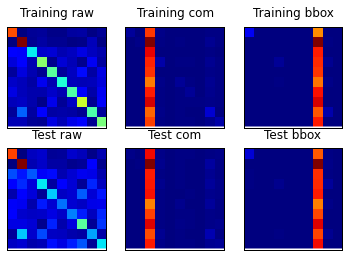

In [32]:
from sklearn.metrics import confusion_matrix
cm_train_normal = confusion_matrix(labels_train, pred_train)
cm_train_com = confusion_matrix(labels_train, pred_train_com)
cm_train_bbox = confusion_matrix(labels_train, pred_train_bbox)

cm_test_normal = confusion_matrix(labels_test, pred_test)
cm_test_com = confusion_matrix(labels_test, pred_test_com)
cm_test_bbox = confusion_matrix(labels_test, pred_test_bbox)

#Display examples 
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True)
ax = ax.flatten()

ax[0].matshow(cm_train_normal)
ax[0].set_title('Training raw')

ax[1].matshow(cm_train_com)
ax[1].set_title('Training com')

ax[2].matshow(cm_train_bbox)
ax[2].set_title('Training bbox')

ax[3].matshow(cm_test_normal)
ax[3].set_title('Test raw')

ax[4].matshow(cm_test_com)
ax[4].set_title('Test com')

ax[5].matshow(cm_test_bbox)
ax[5].set_title('Test bbox')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.show()


<a href='#top'>back to top</a><BR>
<a id='nn'></a>
## D. Neural Network Implementation

### D.1 Details 

The neural network was implemented using one input, one hidden and one output layer. The output is divided in 10 labels and they were encoded as follows: 

$$
0 = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix} \\
1 = \begin{bmatrix} 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix} \\
2 = \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix} \\
\vdots \\
9 = \begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \end{bmatrix} \\
$$

It is necessary to point out that $A^{(3)} = h(Z^{(3)})$ returns an output vector $t$ that has to be compared to encoded input in the cost function.

In [40]:
import numpy as np
from scipy.special import expit

class NeuralNetwork(object):
    
    def __init__(self, n_output=10, n_hidden=30,
                 n_iterations=500, eta=0.001, 
                 alpha=0.0, decrease_const=0.0,  
                 minibatches=1, random_state=None):

        
        self.n_output = n_output
        self.n_hidden = n_hidden
        self.n_iterations = n_iterations
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.minibatches = minibatches
        np.random.seed(random_state)
        
    def _sigmoid(self, z):
        # return 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    def _sigmoid_gradient(self,z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)
    
    def __calculate_cost(self, y_encoded, a3, w1, w2):
        
        #Calculate the cost
        A = -y_encoded * (np.log(a3))
        B = (1 - y_encoded) * np.log(1 - a3)
        cost = np.sum(A - B)

        
        #Calculate regularization l2
        lambda_ = 0.1
        l2 = (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))
        
        #Add regularization to the cost
        cost = cost + l2
        return cost
  
    def _compute_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        sigma3 = a3 - y_enc
        
        #Add row of ones to z2
        z2_bias = np.ones((z2.shape[0]+1, z2.shape[1]))
        z2_bias[1:, :] = z2
        z2 = z2_bias
        
        sigma2 = np.dot(w2.T,sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = np.dot(sigma2, a1)
        grad2 = np.dot(sigma3, a2.T)

        #Regularize
        #TODO: Include lambda_ in the object
        lambda_ =0.1
        grad1[:, 1:] += (w1[:, 1:] * (lambda_))
        grad2[:, 1:] += (w2[:, 1:] * (lambda_))

        return grad1, grad2
    
    def _update_deltas(self,grad1, grad2, delta_w1_ant,delta_w2_ant):
            delta_w1 = self.eta * grad1
            delta_w2 = self.eta * grad2
            
            #Update weights
            self.w1_ -= (delta_w1 + (self.alpha * delta_w1_ant))
            self.w2_ -= (delta_w2 + (self.alpha * delta_w2_ant))
            return delta_w1, delta_w2
                
    def __feed_forward(self, X, w1, w2):    
        #This function needs to calculate a_1, z_2, a_2, z_3 and a_3

        #Add column of ones to the features    
        X_bias = np.ones((X.shape[0], X.shape[1]+1))
        X_bias[:, 1:] = X
        
        #Inputs
        a1 = X_bias
        
        #Operations in layer 2
        z2 = np.dot(w1, a1.T)
        a2 = self._sigmoid(z2)
        
        
        #Operations in layer 3        
        #Add row of ones to a2
        a2_bias = np.ones((a2.shape[0]+1, a2.shape[1]))
        a2_bias[1:, :] = a2      
        
        a2 = a2_bias
        z3 = np.dot(w2,a2)
        a3 = self._sigmoid(z3)
        
        return a1, z2, a2, z3, a3
    

        
        
    def fit(self, X, y):

        self.n_features_ = X.shape[1] #Number of columns
        decrease_const = 0.00001
        self.cost_ = []
        self.cost_average_by_batch_ = []
        
        #Encode the output
        y_encoded = np.zeros((self.n_output, y.shape[0]))
        for index, label in enumerate(y):
            y_encoded[label, index] = 1.0

        
        #Initialize weights randomly using an uniform distribution
        self.w1_ = np.random.uniform(-1.0, 1.0, size=self.n_hidden*(X.shape[1] + 1))
        self.w1_ = self.w1_.reshape(self.n_hidden, X.shape[1] + 1)
        self.w2_ = np.random.uniform(-1.0, 1.0, size=self.n_output*(self.n_hidden + 1))
        self.w2_ = self.w2_.reshape(self.n_output, self.n_hidden + 1)
    
        #
        delta_w1_ant = np.zeros(self.w1_.shape)
        delta_w2_ant = np.zeros(self.w2_.shape)
        
        for i in range(self.n_iterations):
            
             #Adaptive learning rate for each iteration
            self.eta /= (1 + decrease_const*i)
            
            #Shuffle training set
            index = np.random.permutation(y.shape[0])
            X, y, y_encoded = X[index], y[index], y_encoded[:,index]
    
    
            #Divide the data to use minibatches in GD
            mini = np.array_split(range(y.shape[0]), self.minibatches)
            for idx in mini:
                
                #Feedforward
                a1, z2, a2, z3, a3 = self.__feed_forward(X[idx], self.w1_, self.w2_)
                cost = self.__calculate_cost(y_encoded[:,idx], a3, self.w1_, self.w2_)
                self.cost_.append(cost)
                
                #print(self.cost_)
                #Back propagation
                grad1, grad2 = self._compute_gradient(a1, a2, a3, z2, y_encoded[:, idx], self.w1_, self.w2_)
                delta_w1_ant, delta_w2_ant = self._update_deltas(grad1, grad2, delta_w1_ant, delta_w2_ant)
                   
        #Calculating the average cost by iteration
        idx_by_iteration = np.array_split(range(len(self.cost_)), self.n_iterations)
        cost_array = np.array(self.cost_)
        self.cost_average_by_batch_ = [np.mean(cost_array[ii]) for ii in idx_by_iteration]
        
        return self
    
    def predict(self, X):
        a1, z2, a2, z3, a3 = self.__feed_forward(X, self.w1_, self.w2_)
        y_pred = np.argmax(z3, axis=0)
        return y_pred
    
    def plot_average_cost(self):
        plt.plot(range(len(self.cost_average_by_batch_)), self.cost_average_by_batch_, color='blue')
        plt.ylim([0, int(np.max(nn.cost_average_by_batch_)/2)])
        plt.ylabel('Average cost')
        plt.xlabel('Iterations')
        plt.title('Average cost by iteration')
        plt.show()
    

In [46]:
#Split the data in 10 datasets
max_sample = 10000

X = x_train[0:max_sample,:]
y = y_train[0:max_sample]
subsets = 3
subsets_idx = np.array_split(range(y.shape[0]), subsets)

tuned_parameters = [{ 'n_iterations': [700]}, 
                    { 'n_hidden': [ 50, 60, 70 ]},
                    { 'eta':[0.001, 0.01]}]


[array([   0,    1,    2, ..., 3331, 3332, 3333]), array([3334, 3335, 3336, ..., 6664, 6665, 6666]), array([6667, 6668, 6669, ..., 9997, 9998, 9999])]


In [42]:
#Cross-validation
def crossvalidation_nn(X_train, y_train):
    t0 = time()
    parameters = []
    models = []
    for idx in subsets_idx:

        for idx_iter in tuned_parameters[0].get('n_iterations'):

            for idx_hidden in tuned_parameters[1].get('n_hidden'):

                for idx_eta in tuned_parameters[2].get('eta'):

                    nn = NeuralNetwork(n_output=10, 
                              n_hidden=idx_hidden, 
                              n_iterations=idx_iter, 
                              eta=idx_eta,
                              alpha=0.001,
                              decrease_const=0.00001,
                             minibatches=50, 
                             random_state=1)


                    models.append(nn.fit(X_train[idx], y_train[idx]))
                    parameters.append("n_iterations = {}, n_hidden = {}, eta = {}".format(idx_iter, idx_hidden, idx_eta))


    print('Crossvalidation time : ' + "%.4f" % (time()-t0) + ' seconds') 


    accuracy = []
    for ii in range(len(models)):
        accuracy_partial = 0
        for jj in range(subsets):
            if ii != jj:
                indices = subsets_idx[jj]
                accuracy_partial += accuracy_score(y_train[indices], models[ii].predict(X_train[indices]))
        accuracy.append(accuracy_partial/(subsets-1))
    
    max_value = max(accuracy)
    max_index = accuracy.index(max_value)
    print(" Best parameters {0} accuracy = {1:.4f}".format(parameters[max_index], max_value))

    return accuracy

In [47]:
#Crossvalidation using the three dataset
accuracy_normal = crossvalidation_nn(X,y)  

Crossvalidation time : 2970.6633 seconds
 Best parameters n_iterations = 700, n_hidden = 60, eta = 0.01 accuracy = 0.7919


NN training time : 376.7292 seconds
Training accuracy: 0.9961%


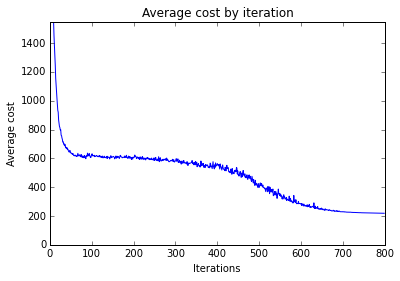

In [51]:
#Look for the optimum number of iterations
nn = NeuralNetwork(n_output=10, 
          n_hidden=60, 
          n_iterations=800, 
          eta=0.01,
          alpha=0.001,
          decrease_const=0.00001,
         minibatches=50, 
         random_state=1)

t0 = time()
nn.fit(X, y)
print('NN training time : ' + "%.4f" % (time()-t0) + ' seconds')
y_train_pred = nn.predict(X)
print('Training accuracy: %.4f%%' % accuracy_score(y, y_train_pred))
nn.plot_average_cost()

From the last figure, it is possible to see that the algorithm converge around 700 iterations.

In [ ]:
features_train, features_test, labels_train, labels_test =\
   cross_validation.train_test_split(X_train, y_train, test_size=0.3, random_state=42)
    
features_train_com, features_test_com, labels_train, labels_test =\
   cross_validation.train_test_split(im_train_com, y_train, test_size=0.3, random_state=42)

features_train_bbox, features_test_bbox, labels_train, labels_test =\
   cross_validation.train_test_split(im_train_bbox, y_train, test_size=0.3, random_state=42)

In [52]:
#Look for the optimum number of iterations
nn = NeuralNetwork(n_output=10, 
          n_hidden=60, 
          n_iterations=800, 
          eta=0.01,
          alpha=0.001,
          decrease_const=0.00001,
         minibatches=50, 
         random_state=1)

nn_com = NeuralNetwork(n_output=10, 
          n_hidden=60, 
          n_iterations=800, 
          eta=0.01,
          alpha=0.001,
          decrease_const=0.00001,
         minibatches=50, 
         random_state=1)

nn_bbox = NeuralNetwork(n_output=10, 
          n_hidden=60, 
          n_iterations=800, 
          eta=0.01,
          alpha=0.001,
          decrease_const=0.00001,
         minibatches=50, 
         random_state=1)

In [53]:
t0 = time()
nn.fit(features_train, labels_train)
print('NN training time : ' + "%.4f" % (time()-t0) + ' seconds')

NN training time : 1045.0680 seconds


In [54]:
t0 = time()
nn_com.fit(features_train, labels_train)
print('NN training (com) time : ' + "%.4f" % (time()-t0) + ' seconds')

NN training (com) time : 1047.3902 seconds


In [55]:
t0 = time()
nn_bbox.fit(features_train, labels_train)
print('NN training (bbox) time : ' + "%.4f" % (time()-t0) + ' seconds')

NN training (bbox) time : 1039.3305 seconds


In [56]:
y_train_pred_nn = nn.predict(features_train)
y_test_pred_nn = nn.predict(features_test)
print('Training accuracy normal: %.4f%%' % accuracy_score(labels_train, y_train_pred_nn))
print('Test accuracy normal: %.4f%%' % accuracy_score(labels_test, y_test_pred_nn))

y_pred_train_com = nn_com.predict(features_train_com)
y_pred_test_com = nn_com.predict(features_test_com)
print('Training accuracy com: %.4f%%' % accuracy_score(labels_train, y_pred_train_com))
print('Test accuracy com: %.4f%%' % accuracy_score(labels_test, y_pred_test_com))

y_pred_train_bbox = nn_bbox.predict(features_train_bbox)
y_pred_test_bbox = nn_bbox.predict(features_test_bbox)
print('Training accuracy bbox: %.4f%%' % accuracy_score(labels_train, y_pred_train_bbox))
print('Test accuracy bbox: %.4f%%' % accuracy_score(labels_test, y_pred_test_bbox))

Training accuracy normal: 0.8930%
Test accuracy normal: 0.4122%
Training accuracy com: 0.1479%
Test accuracy com: 0.1280%
Training accuracy bbox: 0.1247%
Test accuracy bbox: 0.1221%


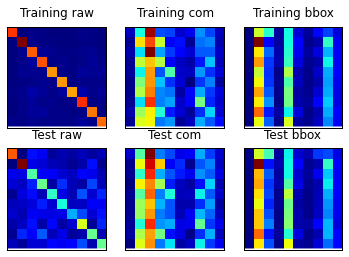

In [57]:
from sklearn.metrics import confusion_matrix
cm_train_normal_nn = confusion_matrix(labels_train, y_train_pred_nn)
cm_train_com_nn = confusion_matrix(labels_train, y_pred_train_com)
cm_train_bbox_nn = confusion_matrix(labels_train, y_pred_train_bbox)

cm_test_normal_nn = confusion_matrix(labels_test, y_test_pred_nn)
cm_test_com_nn = confusion_matrix(labels_test, y_pred_test_com)
cm_test_bbox_nn = confusion_matrix(labels_test, y_pred_test_bbox)

#Display examples 
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True)
ax = ax.flatten()

ax[0].matshow(cm_train_normal_nn)
ax[0].set_title('Training raw')

ax[1].matshow(cm_train_com_nn)
ax[1].set_title('Training com')

ax[2].matshow(cm_train_bbox_nn)
ax[2].set_title('Training bbox')

ax[3].matshow(cm_test_normal_nn)
ax[3].set_title('Test raw')

ax[4].matshow(cm_test_com_nn)
ax[4].set_title('Test com')

ax[5].matshow(cm_test_bbox_nn)
ax[5].set_title('Test bbox')

ax[0].set_xticks([])
ax[0].set_yticks([])

plt.show()

<a href='#top'>back to top</a><BR>
<a id='cnn'></a>
## E. Convolutional neural network

The code for CNN is mainly based on Deep Learning Tutorials:<br\>
http://deeplearning.net/tutorial/lenet.html & http://deeplearning.net/tutorial/code/convolutional_mlp.py

Run with python 2.7

In [23]:
import theano
import theano.tensor as T
from theano import function
from theano import shared
from theano.sandbox.rng_mrg import MRG_RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv

import os
import time
import numpy
from pandas import DataFrame, Series
import pandas as pd

### E.1 Load dataset <br\>
Divide the training set into train set with the first 40000 entries and valid set with last 10000 entries
Store the data into GPU memory to improve performance

In [ ]:
def load_data():
    x_train = numpy.load('dataset/data_and_scripts/train_inputs.npy')
    y_train = numpy.load('dataset/data_and_scripts/train_outputs.npy')
    test_set = numpy.load('dataset/data_and_scripts/test_inputs.npy')
    train_set=[x_train[0:40000,:],y_train[0:40000]]
    valid_set=[x_train[40000:,:],y_train[40000:]]

    def shared_dataset(data_xy, borrow=True):
        ''' Function that loads the dataset into shared variables 
        This will store the dataset into GPU memory
        This will increase performance
        '''
        data_x, data_y = data_xy
        shared_x = theano.shared(numpy.asarray(data_x,dtype=theano.config.floatX),borrow=borrow)
        shared_y = theano.shared(numpy.asarray(data_y,dtype=theano.config.floatX),borrow=borrow)
        return shared_x, T.cast(shared_y, 'int32')

    test_set_x = theano.shared(numpy.asarray(test_set,dtype=theano.config.floatX),borrow=True)
    valid_set_x, valid_set_y = shared_dataset(valid_set)
    train_set_x, train_set_y = shared_dataset(train_set)

    rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y),test_set_x]
    return rval

In [ ]:
class LogisticRegression(object):
    def __init__(self, input, n_in, n_out):
        self.W = theano.shared(value=numpy.zeros((n_in, n_out),dtype=theano.config.floatX),name='W', borrow=True)
        self.b = theano.shared(value=numpy.zeros((n_out,),dtype=theano.config.floatX),name='b', borrow=True)
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)
        self.params = [self.W, self.b]

    def negative_log_likelihood(self, y):
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

    def errors(self, y):
        if y.ndim != self.y_pred.ndim:
            raise TypeError('y should have the same shape as self.y_pred',
                ('y', target.type, 'y_pred', self.y_pred.type))
        if y.dtype.startswith('int'):
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()
            
    def predict(self):
        return self.y_pred
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,activation=T.tanh):
        self.input = input

        if W is None:
            W_values = numpy.asarray(rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)), dtype=theano.config.floatX)
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (lin_output if activation is None
                       else activation(lin_output))
        # parameters of the model
        self.params = [self.W, self.b]

class LeNetConvPoolLayer(object):

    def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2)):        
        assert image_shape[1] == filter_shape[1]
        self.input = input
        fan_in = numpy.prod(filter_shape[1:])
        fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:])/
                   numpy.prod(poolsize))
        W_bound = numpy.sqrt(6. / (fan_in + fan_out))
        self.W = theano.shared(numpy.asarray(rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
            dtype=theano.config.floatX),borrow=True)

        b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True)

        conv_out = conv.conv2d(input=input, filters=self.W,filter_shape=filter_shape, image_shape=image_shape)

        pooled_out = downsample.max_pool_2d(input=conv_out,ds=poolsize, ignore_border=True)

        self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

        self.params = [self.W, self.b]
    
    def return_output():
        return self.output

### E2. Building the CNN model

In [ ]:
learning_rate=0.1
nkerns=[20, 50]
batch_size=500

rng = numpy.random.RandomState(23455)

datasets = load_data()

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x = datasets[2]

n_train_batches = train_set_x.get_value(borrow=True).shape[0]
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
n_test_batches = test_set_x.get_value(borrow=True).shape[0]
n_train_batches /= batch_size
n_valid_batches /= batch_size
n_test_batches /= batch_size

index = T.lscalar()
x = T.matrix('x')
y = T.ivector('y')  

ishape = (48, 48)

layer0_input = x.reshape((batch_size, 1, ishape[0], ishape[1]))

layer0 = LeNetConvPoolLayer(rng, input=layer0_input,
            image_shape=(batch_size, 1, ishape[0], ishape[1]),
            filter_shape=(nkerns[0], 1, 5, 5), poolsize=(2, 2))

layer01 = LeNetConvPoolLayer(rng, input=layer0.output,
            image_shape=(batch_size, nkerns[0], 22, 22),
            filter_shape=(nkerns[0], nkerns[0], 3, 3), poolsize=(2, 2))

layer1 = LeNetConvPoolLayer(rng, input=layer01.output,
            image_shape=(batch_size, nkerns[0], 10, 10),
            filter_shape=(nkerns[1], nkerns[0], 3, 3), poolsize=(2, 2))

layer2_input = layer1.output.flatten(2)

layer2 = HiddenLayer(rng, input=layer2_input, n_in=nkerns[1] * 4 * 4,
                         n_out=500, activation=T.tanh)

layer3 = LogisticRegression(input=layer2.output, n_in=500, n_out=10)

cost = layer3.negative_log_likelihood(y)

validate_model = theano.function([index], layer3.errors(y),
            givens={
                x: valid_set_x[index * batch_size: (index + 1) * batch_size],
                y: valid_set_y[index * batch_size: (index + 1) * batch_size]})

params = layer3.params + layer2.params + layer1.params + layer0.params
grads = T.grad(cost, params)

updates = []
for param_i, grad_i in zip(params, grads):
    updates.append((param_i, param_i - learning_rate * grad_i))

train_model = theano.function([index], cost, updates=updates,
          givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]})

### E3. Train the model with stochastic gradient descent


In [ ]:
n_epochs=15

patience = 10000
patience_increase = 2
improvement_threshold = 0.995
validation_frequency = min(n_train_batches, patience / 2)

best_validation_loss = numpy.inf
best_iter = 0

epoch = 0
done_looping = False

while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    for minibatch_index in xrange(n_train_batches):

        iter = (epoch - 1) * n_train_batches + minibatch_index

        if iter % 100 == 0:
            print 'training @ iter = ', iter
        cost_ij = train_model(minibatch_index)

        if (iter + 1) % validation_frequency == 0:

            validation_losses = [validate_model(i) for i
                                    in xrange(n_valid_batches)]
            this_validation_loss = numpy.mean(validation_losses)
            print('epoch %i, validation error %f %%' % \
                      (epoch, this_validation_loss * 100.))

            if this_validation_loss < best_validation_loss:

                if this_validation_loss < best_validation_loss *  \
                       improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                best_validation_loss = this_validation_loss
                best_iter = iter

        if patience <= iter:
            done_looping = True
            break

### E4. Prediction on the test set

In [ ]:
model_predict = theano.function([index], layer3.y_pred,
         givens={x: test_set_x[index * batch_size: (index + 1) * batch_size]})

### E5. CNN Result
We compute 10 epochs with validation error that significantly decreases from 76% to 27%.
There was little parameter selection involved with convolutional neural network.
The network was trained on 40000 data samples, and the last 1000 were used as validation set. 

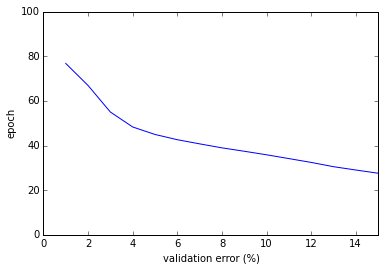

In [24]:
epoch=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
validation_error=[76.77,66.88,54.99,48.3,44.95,42.6,40.74,38.95,37.43,35.84,34.14,32.42,30.51,29.02,27.58]
plt.plot(epoch, validation_error, color='blue')
plt.axis([0, len(epoch), 0, 100])
plt.xlabel('validation error (%)')
plt.ylabel('epoch')

<a href='#top'>back to top</a><BR>
<a id='conclusion'></a>
# IV. Conclusion




As you can see in the next tables, the neural networks has the best results using the original data. According to the results, modifiying the images with *centered with center of mass*  and the *centered with bounding box* did not perfom well. This is due to the fact that the images, that have 48 x 48 pixels, are unrolled as an array and the algorithms are not able to separate the data.

This table shows the results of the classifiers in the training set.

| Algorithm\Accuracy | Original  | COM     | BBOX      |
| :-                 |---------: | :-:     | :-:       |
| Linear regression  | 0.4736%   | 0.4335% | 0.4610%   |
| LinearSVC          | 0.5156%   | 0.1239% | 0.1231%   |
| Neural Network     | 0.8930%   | 0.1479% | 0.1247%   |

This table shows the results of the classifiers in the test set.

| Algorithm\Accuracy | Original  | COM     | BBOX      |
| :-                 |---------: | :-:     | :-:       | 
| Linear regression  | 0.3665%   | 0.2379% | 0.2585%   |
| LinearSVC          | 0.3464%   | 0.1069% | 0.1149%   |
| Neural Network     | 0.4122%   | 0.1280% | 0.1221%   |

As expected, our CNN performed best among the classifiers tested. CNN improved its performance with the number of epochs. However, from previous literature on the MNIST dataset, the best result of CNN is achieved with an error rate of 0.23%. The error rate of our CNN (27.58%) is much greater than expected. This difference is firstly suspected to be caused by the low number of epochs. By increasing the number of epochs, the performance of CNN should increase [6]. Another consideration is that no preprocessing is computated on CNN before excution in contrast to the width normalization that previous literature suggests. This would likely give an additional boost to performance.

In kaggle just two algorithms were used, the results were obtained using the original data. The score for neural network was **0.40550 ** and a score of  **0.73640** for CNN.

<a href='#top'>back to top</a><BR>
<a id='statec'></a>
# V. Statement of Contribution

Edgar E. Garcia-Cano Castillo implemented the neural network algorithm and performed the experiments with logistic regression, linearSVC and neural network.

Alec Turner implemented the preprocessing algorithms.

Meng Miao Wu implemented the CNN algorithms and performed the experiments with it.

All members of the team contributed to the writing of the report.

<a href='#top'>back to top</a><BR>
<a id='stateh'></a>
# VI. Statement of Honesty



We hereby state that all the work presented in this report is that of the authors.

<a href='#top'>back to top</a><BR>
<a id='ref'></a>
# VII. References

[1]: F. Pedregosa, G. Varoquaux, A. Gramfort, V. Michel, B. Thirion, O. Grisel, M. Blondel, P. Prettenhofer, R. Weiss, V. Dubourg, et al., "Scikit-learn: Machine learning in python," The Journal of Machine Learning Research, vol. 12, pp. 2825–2830, 2011.<br />

[2]: F. Rosenblatt, "The Perceptron, a Perceiving and Recognizing Automaton." Cornell Aeronautical Laboratory, 1957.<br />

[3]: R.  Mehrotra, K.  Namuduri and N.  Ranganathan, "Gabor filter-based edge detection", Pattern Recognition, vol. 25, no. 12, pp. 1479-1494, 1992.<br />

[4]: S. Van Der Walt, S. C. Colbert, and G. Varoquaux, "The numpy array: a structure for efficient numerical computation", Computing in Science & Engineering, vol. 13, no. 2, pp. 22–30, 2011.<br />

[5]: W. McKinney, "Data structures for statistical computing in python", in Proceedings of the 9th Python in Science Conference (S. van der Walt and J. Millman, eds.), pp. 51 – 56, 2010.<br />

[6]: W. S. McCulloch and W. Pitts. "A Logical Calculus of the Ideas Immanent in Nervous Activity." The bulletin of mathematical biophysics, 5(4):115–133, 1943).<br />

[7]: F. Pedregosa, G. Varoquaux, A. Gramfort, V. Michel, B. Thirion, O. Grisel, M. Blondel, P. Prettenhofer, R. Weiss, V. Dubourg, J. Vanderplas, A. Passos,D. Cournapeau, M. Brucher, M. Perrot, and E. Duchesnay. "Scikit-learn: Machine learning in Python." Journal of Machine Learning Research, 12:2825–2830, 2011.

[8:] S. Raschka, "Python Machine Learning", Packt Publishing Ltd. (September 24th, 2015)